In [2]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit
from lcls_beamline_toolbox.xraybeamline2d import beam as beam, optics as optics, beamline2d as beamline

Can't find epics package. PPM_Imager class will not be supported


## LCLS-II-HE parameter definitions

## To do list
Incorporate parameters from LCLS-II-HE Undulator Performance document. \
Fit 7 to 14 keV separately from 15 to 18 keV, since they changed the quadrupole settings at that point. \
Can just linearly interpolate between 14 and 15 keV for now. \
Mirror length 600mm \
Working distance 750mm \
Also simulate 30 um case, with focus upstream.

In [3]:
file_path = '/Users/seaberg/OneDrive - SLAC National Accelerator Laboratory/Beam Delivery/CXI HE upgrade/'
df = pd.read_csv(file_path+'HXR_100pC_distilled.csv')
#print(df['Photon energy (keV)'])

# generic function for curve_fit
def generic_curve(x,a,b,c):
    
    return a*x**b + c

energy = np.array(df['Photon energy'])
z_source = np.array(df['z_source'])
div_x = np.array(df['div_x'])
div_y = np.array(df['div_y'])
sigma_x = np.array(df['sigma_x'])
sigma_y = np.array(df['sigma_y'])
div_x_rms = np.array(df['div_x_rms'])
div_y_rms = np.array(df['div_y_rms'])

def generate_fit(data, quantity):
    
    energy = np.array(df['Photon energy'])
    source_quantity = np.array(df[quantity])
    
#     popt1, pcov1 = curve_fit(generic_curve, energy[0:9], z_source[0:9], method='trf')
#     popt1, pcov1 = curve_fit(generic_curve, energy[0:9], z_source[0:9], p0=[1,1,np.mean(z_source[0:9])])
    p1 = np.polyfit(energy[:9], source_quantity[:9], 3)
    p2 = np.polyfit(energy[9:], source_quantity[9:], 2)
#     popt2, pcov2 = curve_fit(generic_curve, energy[9:], z_source[9:])
#     popt1 = list(popt1)
#     print(*popt1)
    
    def fit_function(E0):
        
        E0 = np.array(E0)
        out = np.zeros_like(E0)
        
        mask1 = E0<=14
#         mask2 = np.logical_not(mask1)
        mask2 = E0>=15
    
        mask3 = np.logical_not(np.logical_or(mask1,mask2))
        
#         out[mask1] = generic_curve(E0[mask1], *popt1)
        out[mask1] = np.polyval(p1, E0[mask1])
#         out[mask2] = np.interp(E0[mask2], energy, z_source)
        out[mask2] = np.polyval(p2, E0[mask2])
        out[mask3] = np.interp(E0[mask3], energy, source_quantity)
        
        return out
#         if energy<=14:
#             return generic_curve(E0, *popt1)
#         else:
#             source_z = np.interp(E0, energy, z_source)
#             return source_z
    
    return fit_function

In [4]:
test = 1

In [5]:
bool_test = test is not None

In [6]:
bool_test

True

In [7]:
source_z_fit = generate_fit(df, 'z_source')
div_x_fit = generate_fit(df, 'div_x')
div_y_fit = generate_fit(df, 'div_y')
sigma_x_fit = generate_fit(df, 'sigma_x')
sigma_y_fit = generate_fit(df, 'sigma_y')
div_x_rms_fit = generate_fit(df, 'div_x_rms')
div_y_rms_fit = generate_fit(df, 'div_y_rms')

<IPython.core.display.Javascript object>


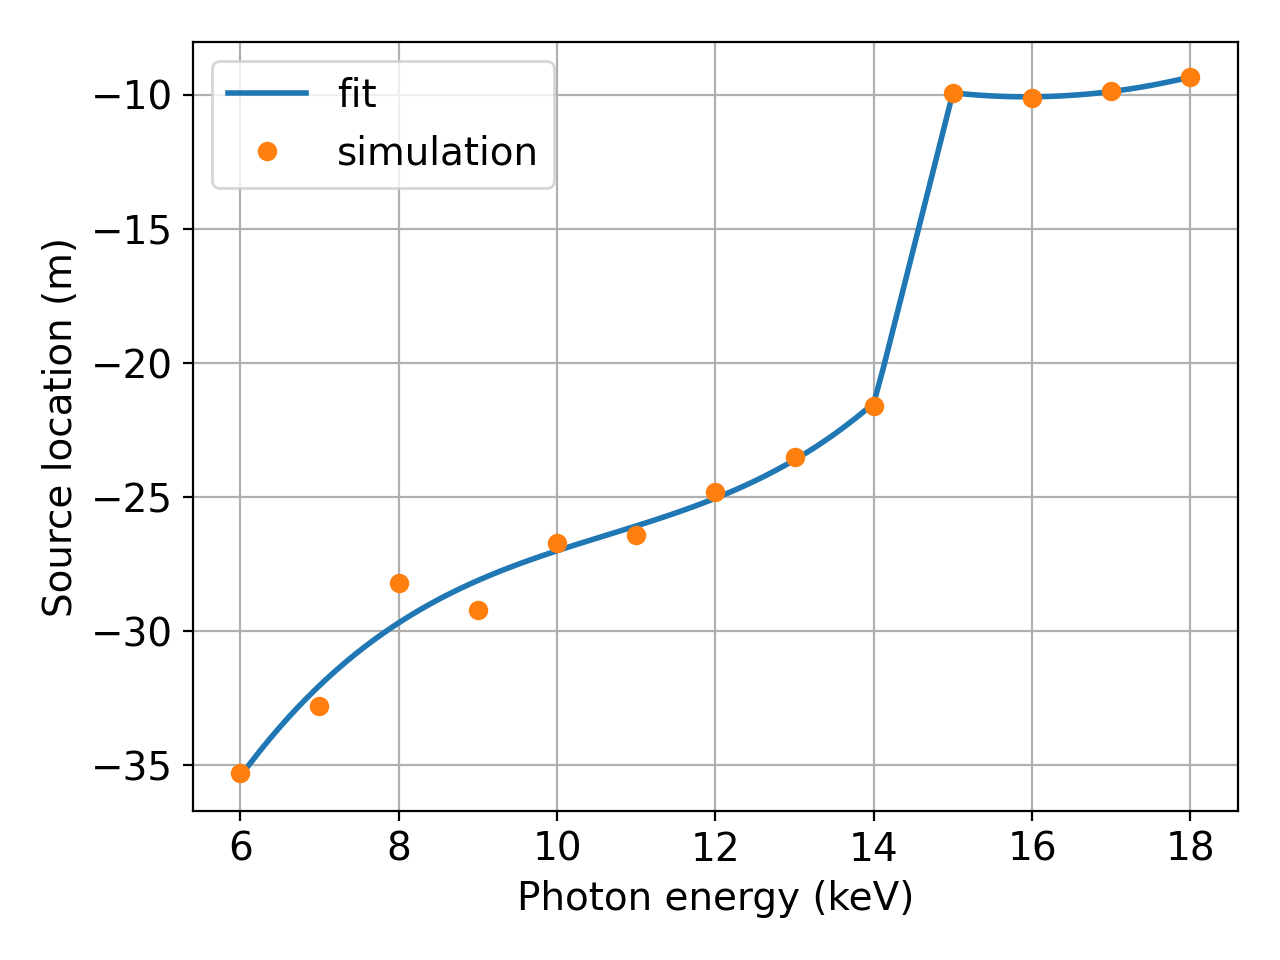

<IPython.core.display.Javascript object>


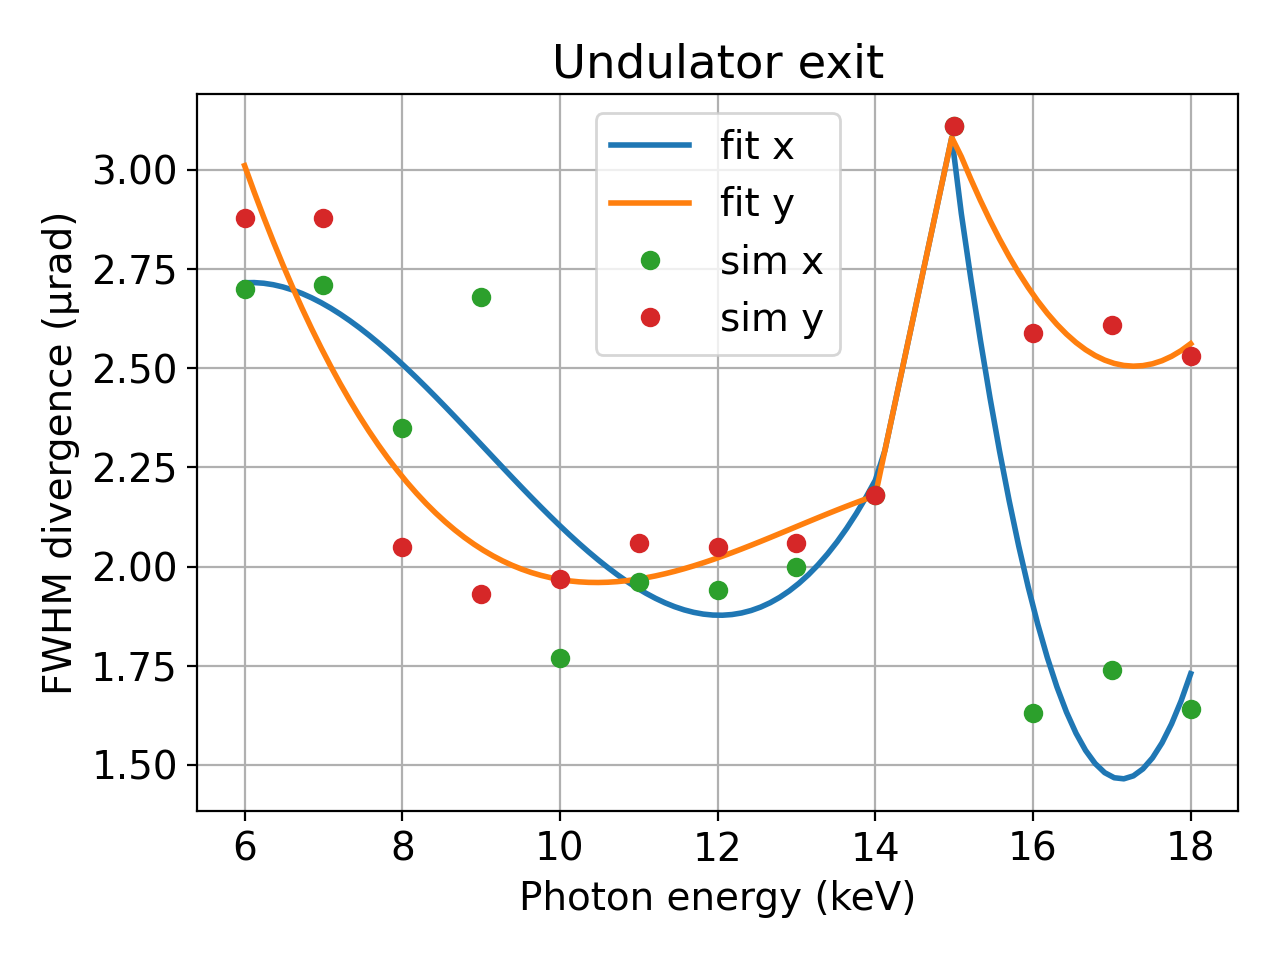

<IPython.core.display.Javascript object>


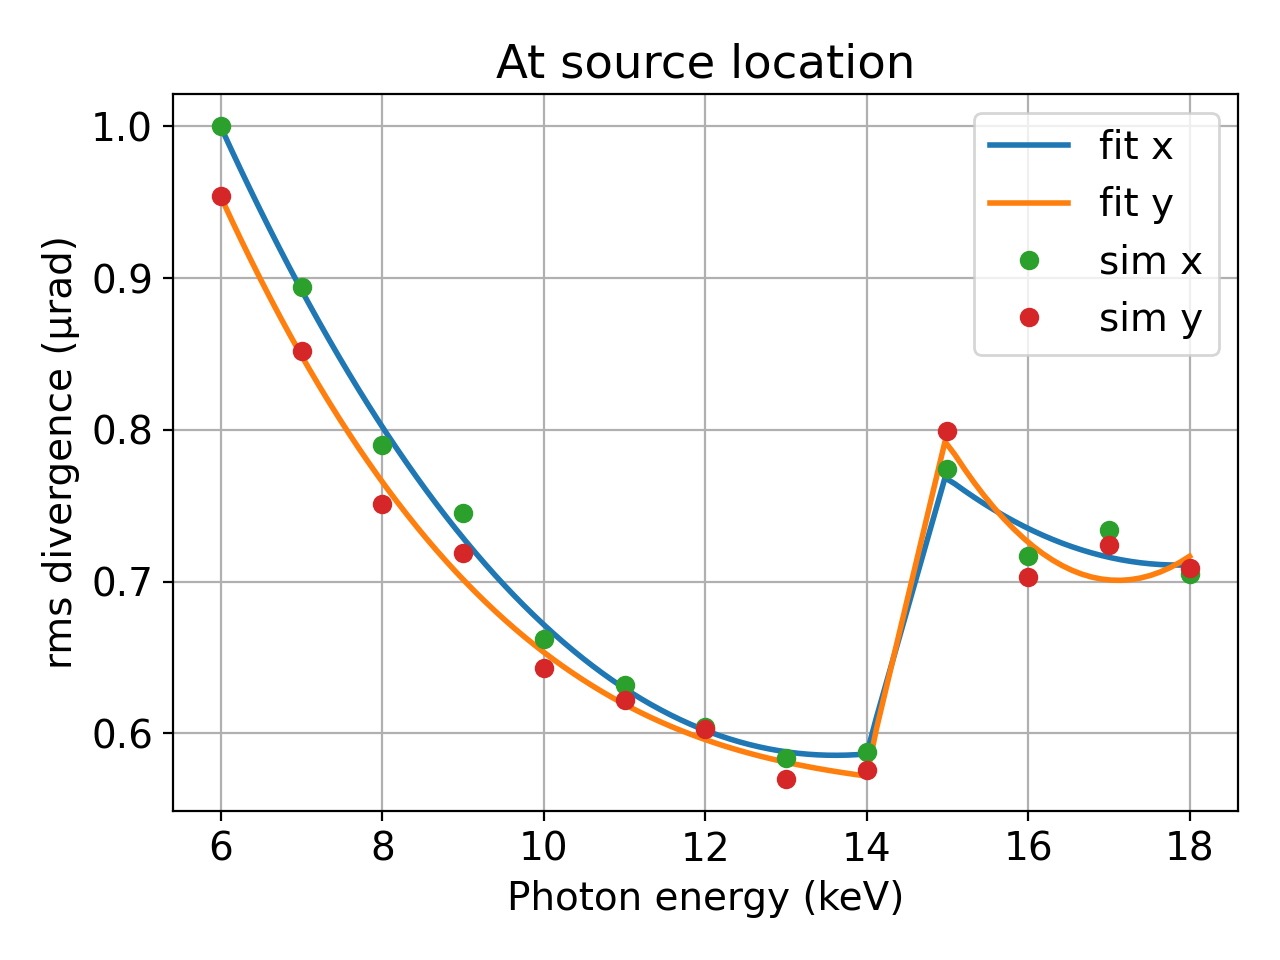

<IPython.core.display.Javascript object>


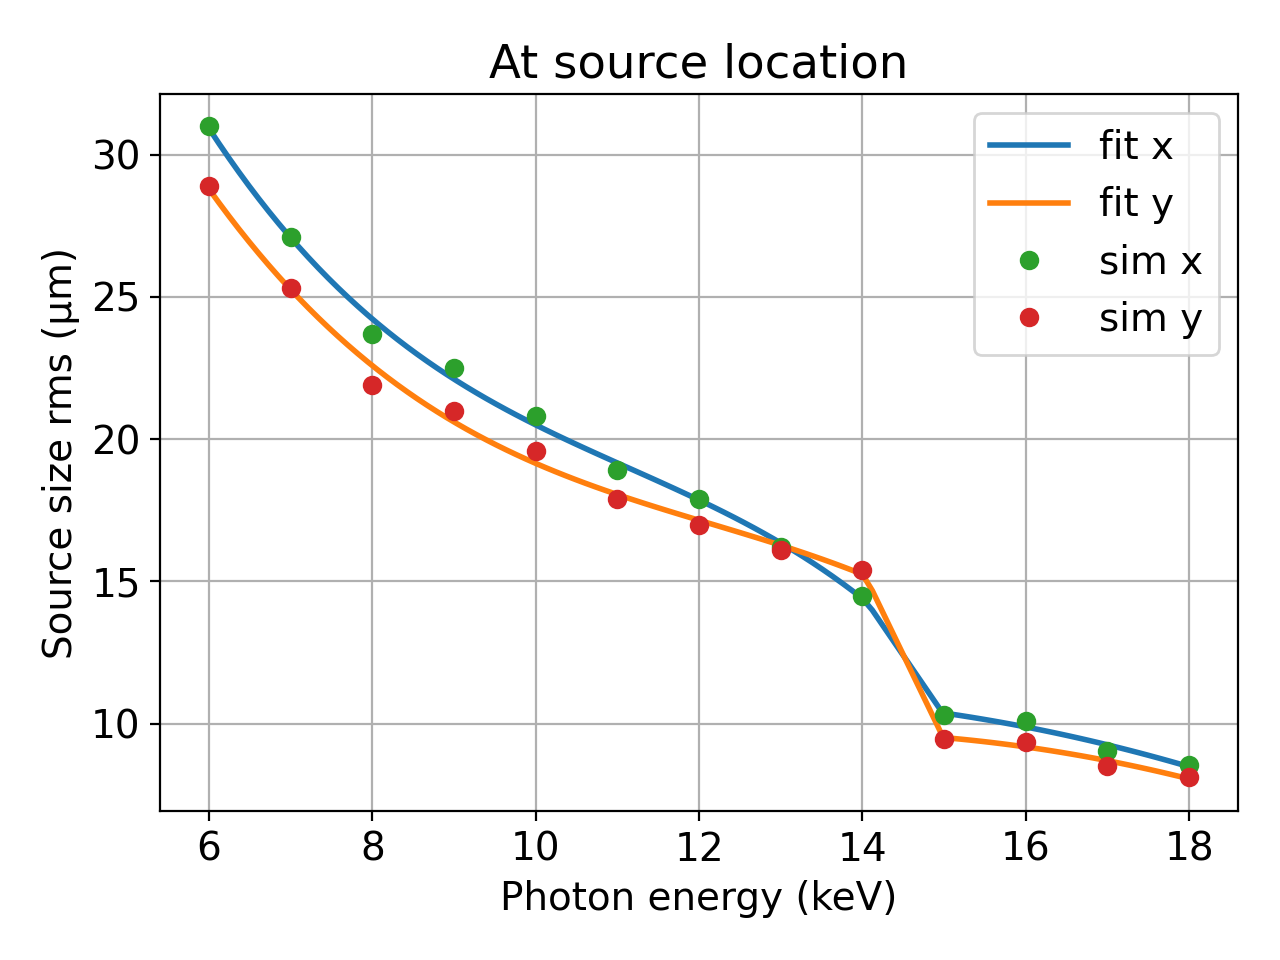

<IPython.core.display.Javascript object>


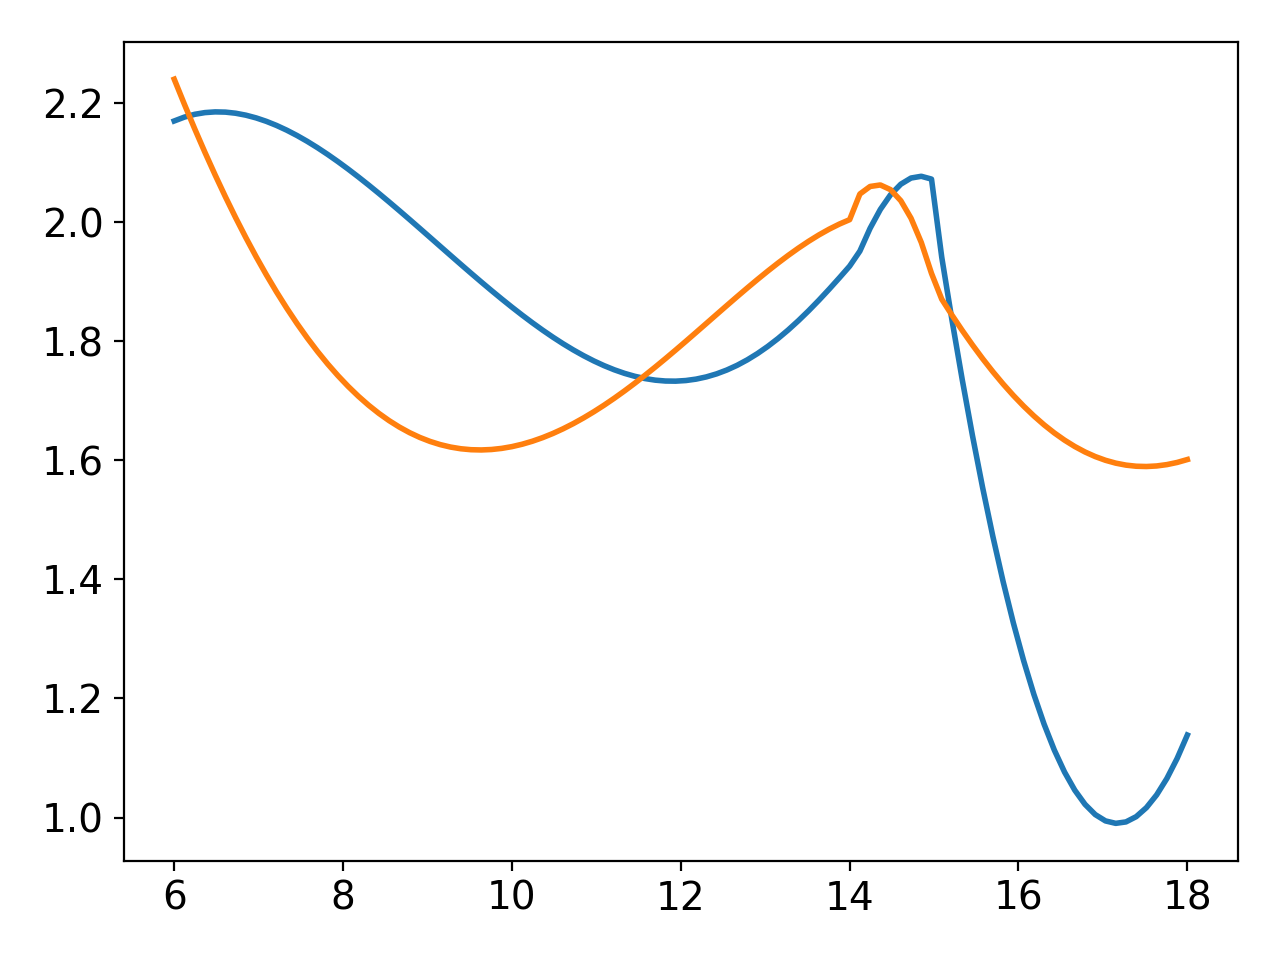

<IPython.core.display.Javascript object>


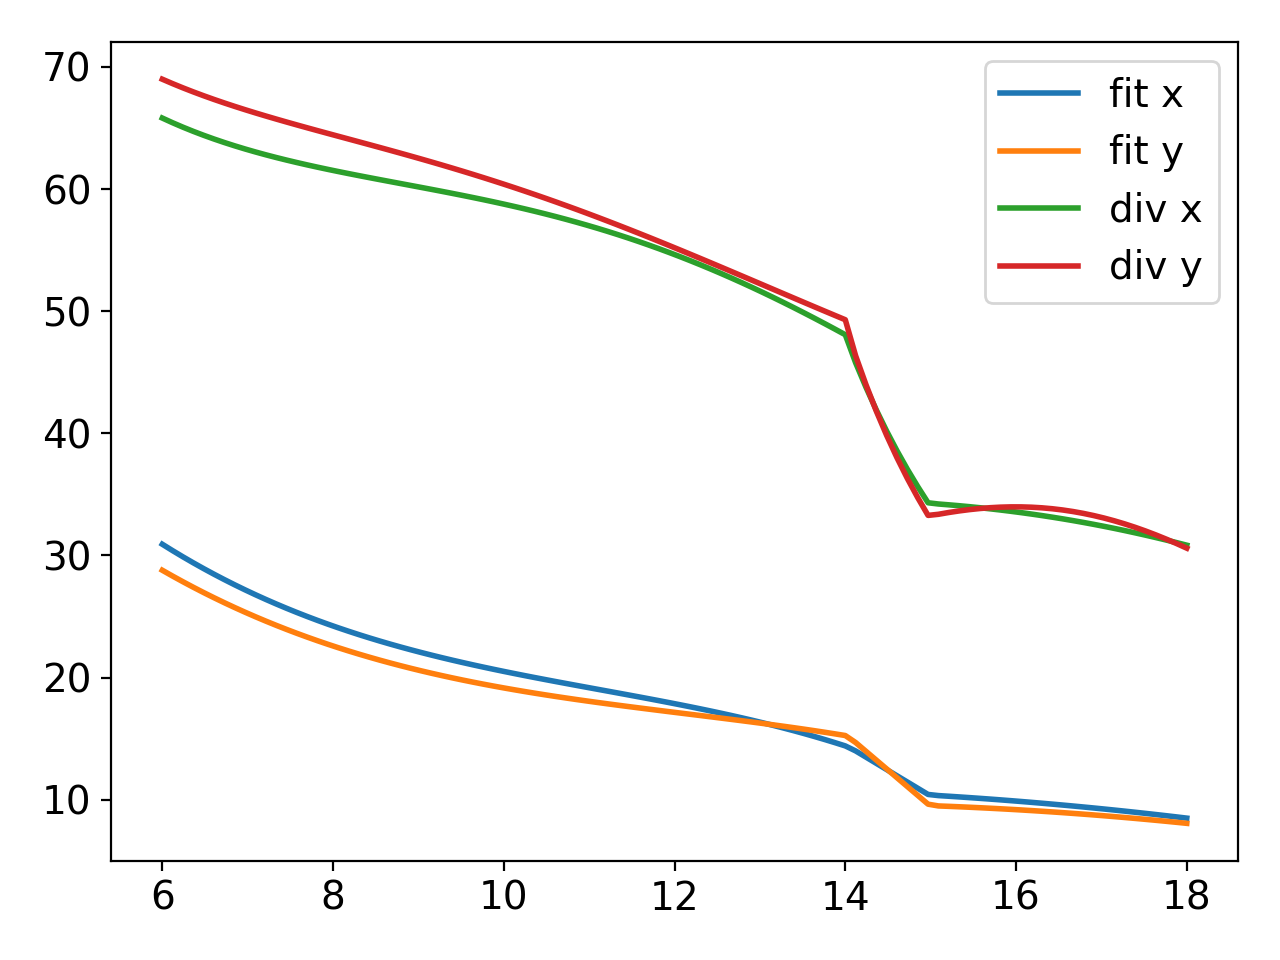

In [8]:
fig_path = file_path + 'figures/'

e_interp = np.linspace(np.min(energy),np.max(energy),100)

# calculate divergence
# divergence_x = self.wavelength / np.pi / self.sigma_x
# divergence_y = self.wavelength / np.pi / self.sigma_y

wavelength = 1239.8/(energy*1000)*1e-9
w_interp = 1239.8/(e_interp*1000)*1e-9

plt.figure()
plt.plot(e_interp, source_z_fit(e_interp),label='fit')
plt.plot(energy, z_source,'o',label='simulation')
plt.grid()
plt.xlabel('Photon energy (keV)')
plt.ylabel('Source location (m)')
plt.legend()
plt.tight_layout()
plt.savefig(fig_path+'source_z.png')

plt.figure()
plt.plot(e_interp, div_x_fit(e_interp),label='fit x')
plt.plot(e_interp, div_y_fit(e_interp),label='fit y')
plt.plot(energy, div_x,'o',label='sim x')
plt.plot(energy, div_y,'o',label='sim y')
plt.grid()
plt.xlabel('Photon energy (keV)')
plt.ylabel('FWHM divergence (\u03BCrad)')
plt.legend()
plt.title('Undulator exit')
plt.tight_layout()
plt.savefig(fig_path+'exit_div_fwhm.png')


plt.figure()
plt.plot(e_interp, div_x_rms_fit(e_interp),label='fit x')
plt.plot(e_interp, div_y_rms_fit(e_interp),label='fit y')
plt.plot(energy, div_x_rms,'o',label='sim x')
plt.plot(energy, div_y_rms,'o',label='sim y')
plt.grid()
plt.xlabel('Photon energy (keV)')
plt.ylabel('rms divergence (\u03BCrad)')
plt.title('At source location')
plt.legend()
plt.tight_layout()
plt.savefig(fig_path+'source_div_rms.png')

plt.figure()
plt.plot(e_interp, sigma_x_fit(e_interp),label='fit x')
plt.plot(e_interp, sigma_y_fit(e_interp),label='fit y')
plt.plot(energy, sigma_x, 'o', label='sim x')
plt.plot(energy, sigma_y, 'o', label='sim y')
plt.grid()
plt.xlabel('Photon energy (keV)')
plt.ylabel('Source size rms (\u03BCm)')
plt.title('At source location')
plt.legend()
plt.tight_layout()
plt.savefig(fig_path + 'source_size_rms.png')

sig_div_x = w_interp/np.pi/(div_x_rms_fit(e_interp)*1e-6)*1e6
sig_div_y = w_interp/np.pi/(div_y_rms_fit(e_interp)*1e-6)*1e6



M2x = div_x_fit(e_interp)*.85*2*sigma_x_fit(e_interp)/w_interp*(np.pi)*1e-12
M2y = div_y_fit(e_interp)*.85*2*sigma_y_fit(e_interp)/w_interp*(np.pi)*1e-12

plt.figure()
plt.plot(e_interp, M2x)
plt.plot(e_interp, M2y)

plt.figure()
plt.plot(e_interp, sigma_x_fit(e_interp),label='fit x')
plt.plot(e_interp, sigma_y_fit(e_interp),label='fit y')
plt.plot(e_interp, w_interp/np.pi/(div_x_rms_fit(e_interp)*1e-6)*1e6,label='div x')
plt.plot(e_interp, w_interp/np.pi/(div_y_rms_fit(e_interp)*1e-6)*1e6,label='div y')
plt.legend()


# plt.plot(e_interp, div_x_rms_fit(e_interp))
# plt.plot(energy, div_x_rms)

### Beam parameters

In [25]:
# number of sampling points
N = 2048
# photon energy in eV
E0 = 6000

# parameter dictionary. z_source is in LCLS coordinates (20 meters upstream of undulator exit)
# beam_params = {
#     'photonEnergy': E0,
#     'N': N,
#     'sigma_x': 27e-6,
#     'sigma_y': 27e-6,
#     'rangeFactor': 5,
#     'scaleFactor': 10,
#     'z0x': 105.6817,
#     'z0y': 106.6817,
#     'z_source': 650-32.8
# }
zs = 650+source_z_fit(E0/1000)
im2l0 = optics.PPM('im2l0', FOV=2e-3, N=1024, z=736.508)

z0 = im2l0.z-zs

beam_params = {
    'photonEnergy': E0,
    'N': N,
#     'sigma_x': sigma_x_fit(E0/1000)*1e-6/1.1,
#     'sigma_y': sigma_y_fit(E0/1000)*1e-6/1.1,
    'sigma_x': 30e-6,
    'sigma_y': 30e-6,
#     'rangeFactor': 5,
#     'scaleFactor': 10,
#     'z0x': z0,
#     'z0y': z0
    'z_source': zs
}

### Define beamline

In [28]:

# initialize the beam
b1 = beam.Beam(beam_params=beam_params)

# pf1l0 = optics.WFS('pf1l0', pitch=15e-6, duty_cycle=1, phase=True, z=735.6817)
# im2l0 = optics.PPM('im2l0', FOV=2e-3, N=1024, z=736.508)

DG1 = optics.PPM('Upstream', FOV=4e-3, z=1029.5)
hfm = optics.CurvedMirror('hfm', length=2, p=440, q=1.7-344e-6, alpha=3.052e-3, z=1029.85, orientation=0,delta=0e-6)
vfm = optics.CurvedMirror('vfm', length=2, p=440, q=1.05-70e-6, alpha=2.742e-3, z=1030.5-40e-6, orientation=1)
DG2 = optics.PPM('Downstream', FOV=1e-3, z=1030.6)

IP = optics.PPM('IP', FOV=1.0e-6, z=1030.5+1.05)

# list of devices to propagate through
devices = [DG1, hfm, vfm, DG2, IP]

# initialize beamline
L_beamline = beamline.Beamline(devices)

FWHM in x: 50.063160108007565 microns
FWHM in y: 50.063160108007565 microns
FWHM Divergence (x): 2.6 μrad
FWHM Divergence (y): 2.6 μrad
x is focused
y is focused
after hfm: 0.0061
after vfm: 0.0055


FWHM in x: 1074.0292272512913 microns
FWHM in y: 1074.0292272512913 microns
FWHM Divergence (x): 2.6 μrad
FWHM Divergence (y): 2.6 μrad
Upstream


/Users/seaberg/beamline/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


zx: 414.924242
zy: 414.924242
azimuth 0.00 mrad
drift1
global_x 0.00
global_y 0.00
x intersect: 0.0000e+00
component x: 0.0000e+00
y intersect: 0.0000e+00
component y: 0.0000e+00
delta z: 0.00
zRx: 393043066.32 microns
zRy: 393043066.32 microns
remaining distance: 350000.00 microns
goal for zx: 415274242.42 microns
current zx: 414924242.42 microns
goal for zy: 415274242.42 microns
current zy: 414924242.42 microns
zx: 415.274242
zy: 415.274242
azimuth 0.00 mrad
hfm
zRx: 6.59e-03
zRy: 3.93e+02
zx: -1.700047
zy: 415.274242
azimuth 6.10 mrad
drift2
global_x 0.00
global_y 0.00
x intersect: 3.9674e-03
component x: 3.9674e-03
y intersect: 0.0000e+00
component y: 0.0000e+00
delta z: 0.00
zRx: 6587.07 microns
zRy: 393043066.32 microns
remaining distance: 649972.11 microns
goal for zx: -1050074.90 microns
current zx: -1700047.01 microns
goal for zy: 415924214.53 microns
current zy: 415274242.42 microns
zx: -1.050075
zy: 415.924215
azimuth 6.10 mrad
vfm
zRx: 6.59e-03
zRy: 2.51e-03
zx: -1.050075
z

<IPython.core.display.Javascript object>


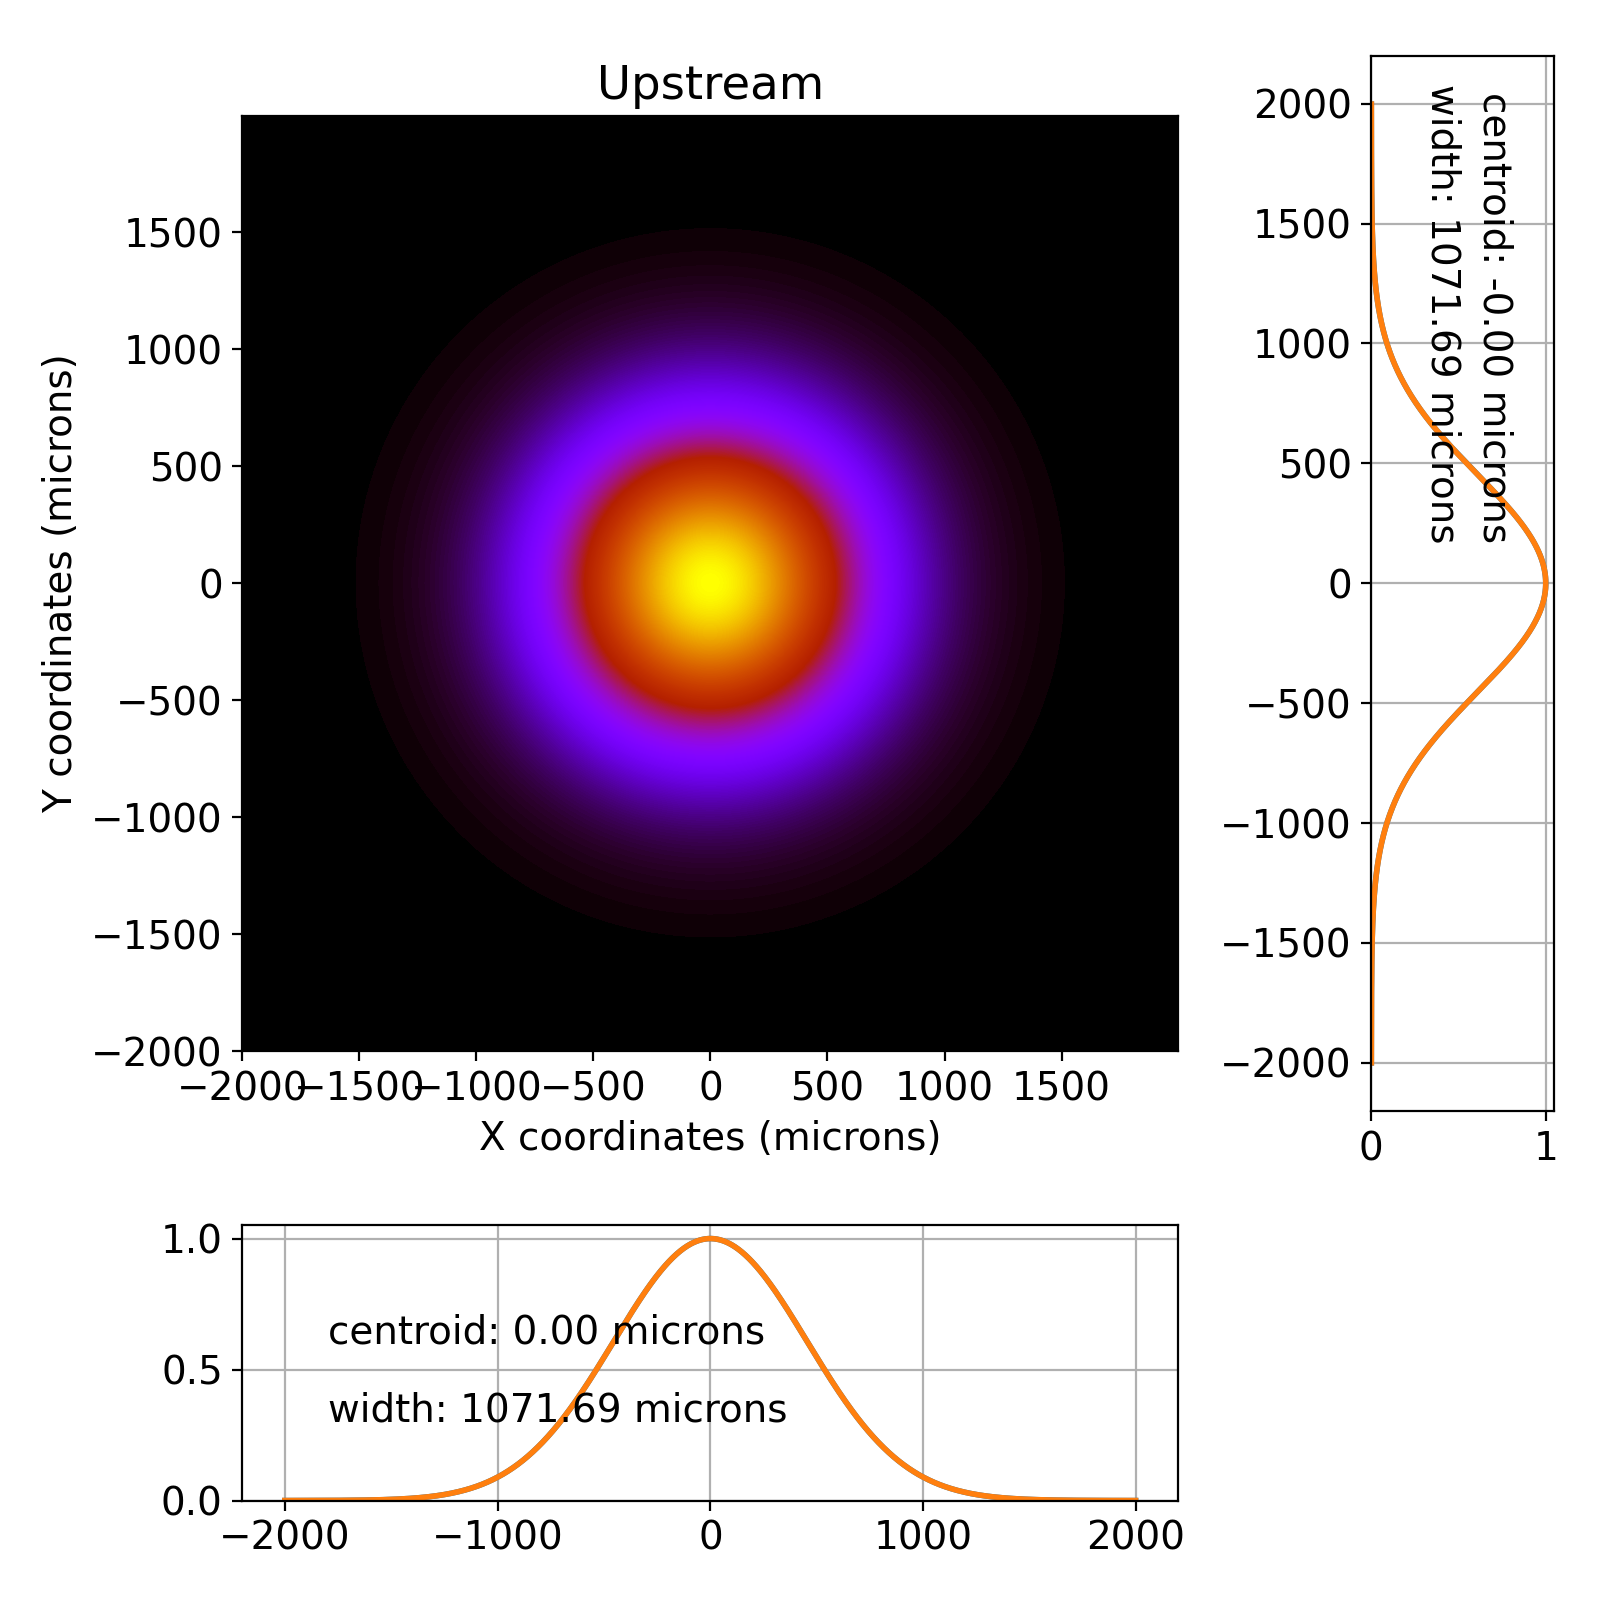

<IPython.core.display.Javascript object>


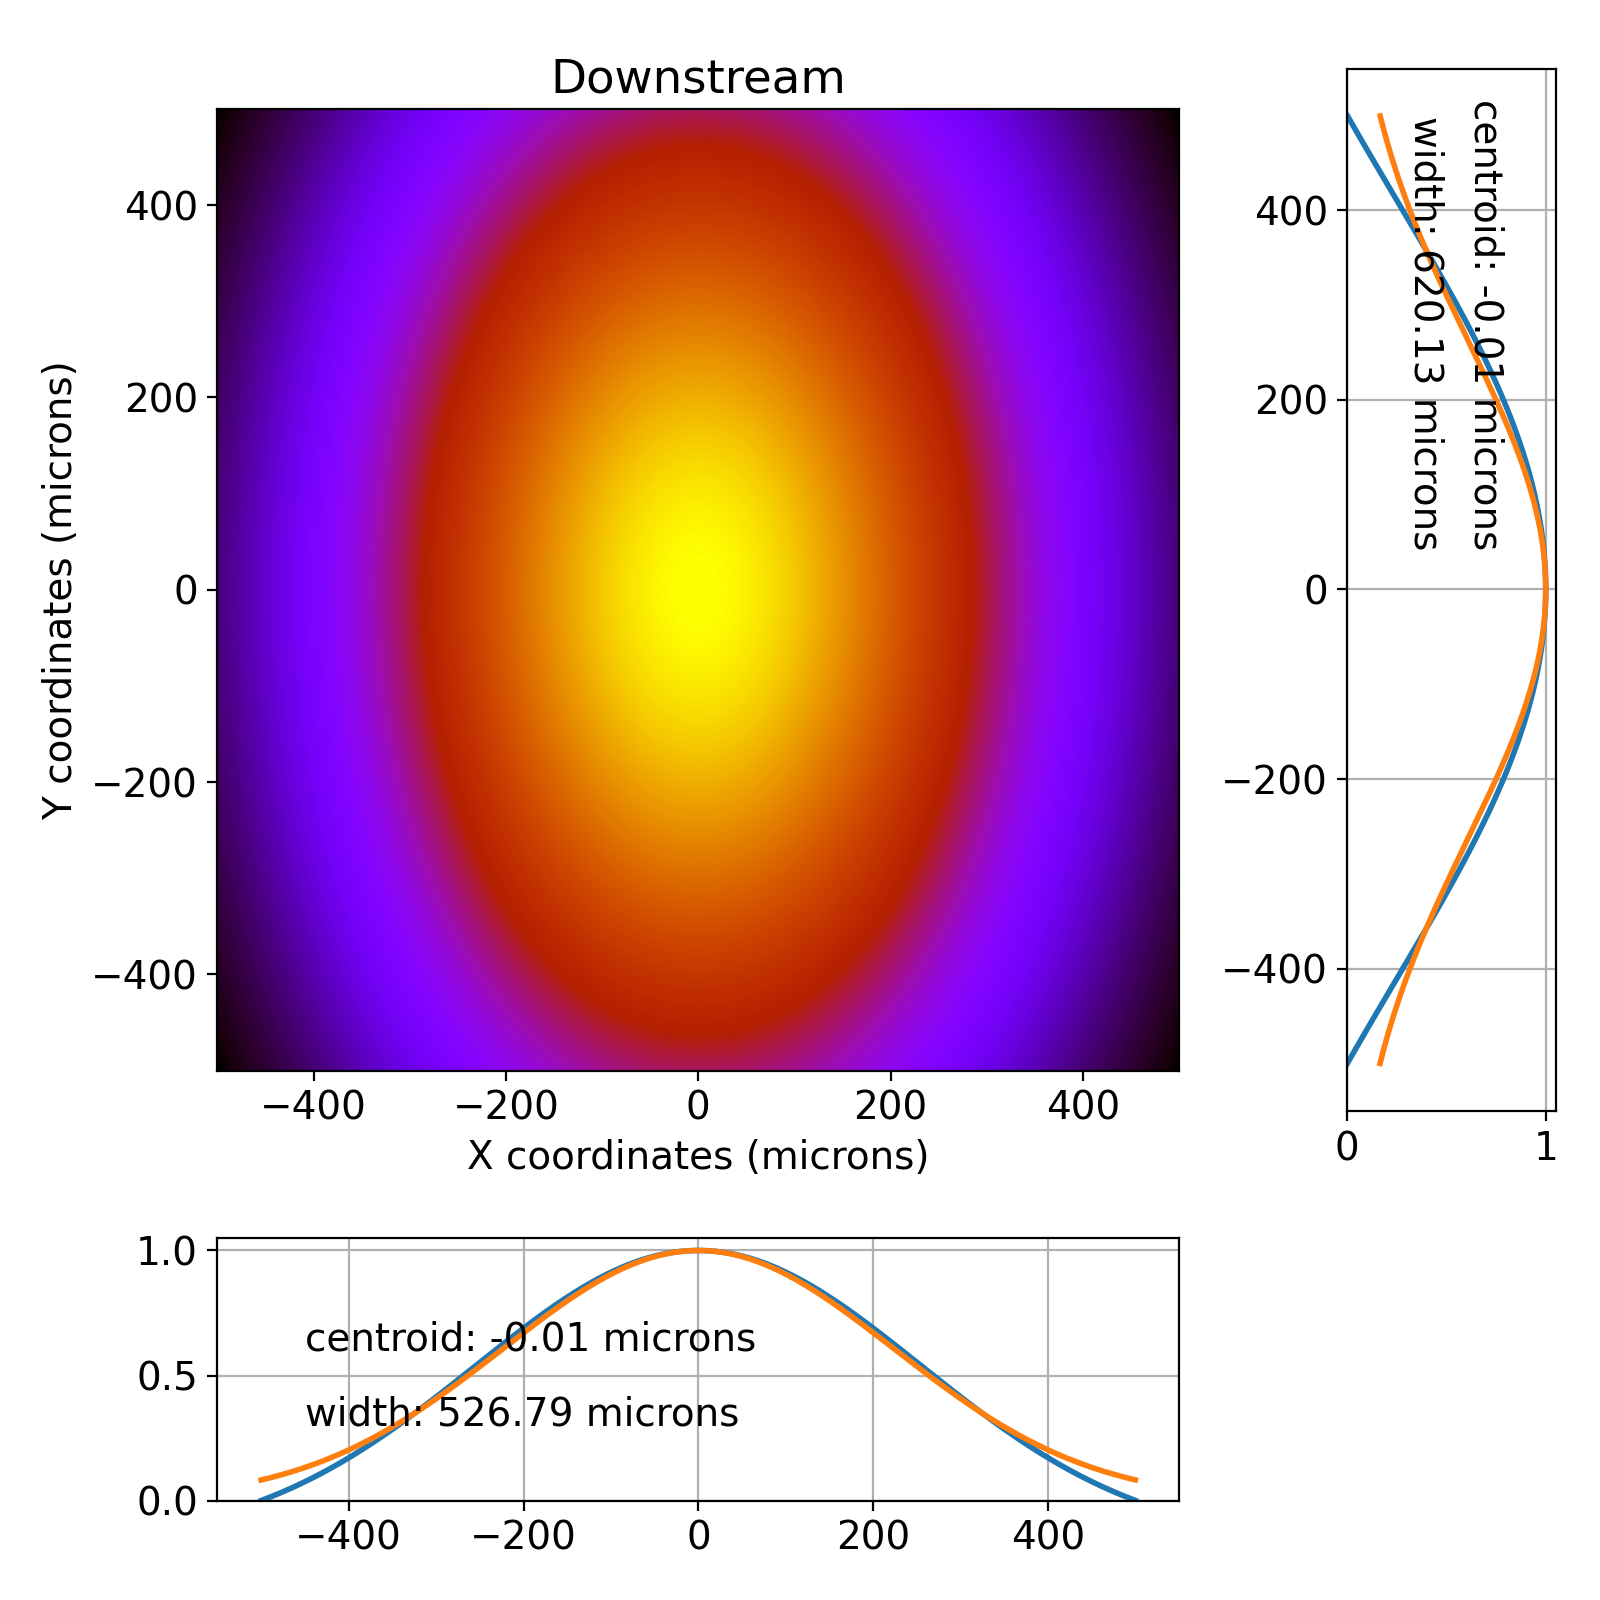

<IPython.core.display.Javascript object>


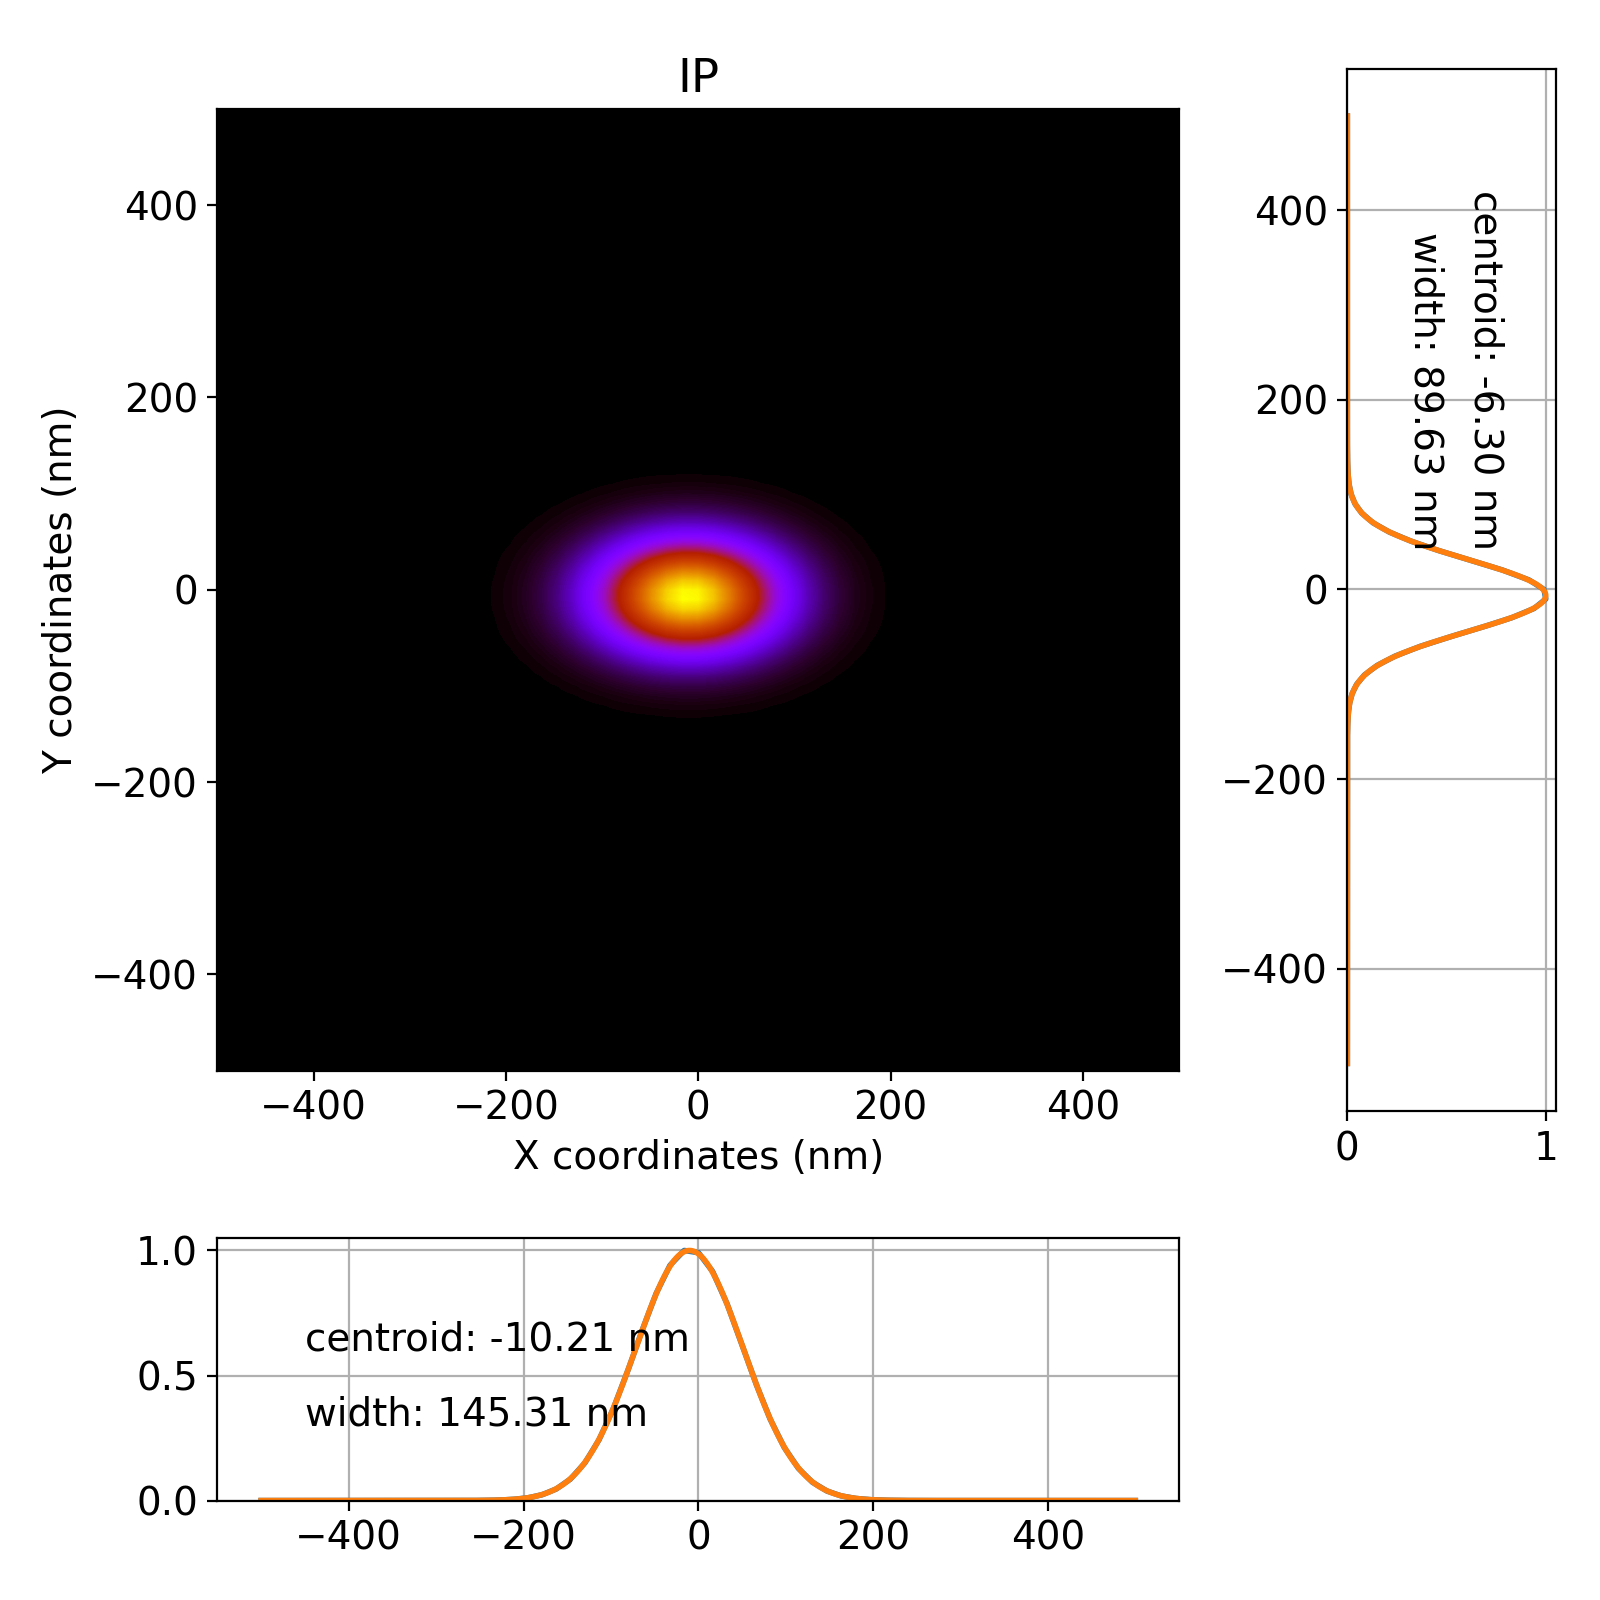

In [29]:
# propagate
b2 = L_beamline.propagate_beamline(b1)

fig_path = '/Users/seaberg/OneDrive - SLAC National Accelerator Laboratory/Beam Delivery/CXI HE upgrade/figures/'

L_beamline.Upstream.view_beam()
# plt.savefig(fig_path+'upstream_KB01.png')
L_beamline.Downstream.view_beam()
# plt.savefig(fig_path+'downstream_KB01.png')
L_beamline.IP.view_beam()
# plt.savefig(fig_path+'IP_KB01.png')

In [11]:
L_beamline.IP.wy

8.307754038941143e-08

In [24]:

# initialize the beam
b1 = beam.Beam(beam_params=beam_params)

# pf1l0 = optics.WFS('pf1l0', pitch=15e-6, duty_cycle=1, phase=True, z=735.6817)
# im2l0 = optics.PPM('im2l0', FOV=2e-3, N=1024, z=736.508)

DG1 = optics.PPM('Upstream', FOV=5e-3, z=1029.5)
hfm = optics.CurvedMirror('hfm', length=.55, p=440, q=1.7-450e-6, alpha=3e-3, z=1029.85, orientation=0,delta=0e-6)
vfm = optics.CurvedMirror('vfm', length=.55, p=440, q=1.05-170e-6, alpha=3e-3, z=1030.5, orientation=1)
DG2 = optics.PPM('Downstream', FOV=5e-3, z=1030.6)

IP = optics.PPM('IP', FOV=2e-6, z=1030.5+1.05)

# list of devices to propagate through
devices = [DG1, hfm, vfm, DG2, IP]

# initialize beamline
L_beamline = beamline.Beamline(devices)

FWHM in x: 41.07876134114969 microns
FWHM in y: 38.31279856199589 microns
FWHM Divergence (x): 2.7 μrad
FWHM Divergence (y): 2.9 μrad
x is focused
y is focused


### Propagation through monochromator at central photon energy

FWHM in x: 1112.5472919893687 microns
FWHM in y: 1192.767847158369 microns
FWHM Divergence (x): 2.7 μrad
FWHM Divergence (y): 2.9 μrad
Upstream


/Users/seaberg/beamline/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


drift1
zRx: 309161517.53 microns
zRy: 268974150.91 microns
remaining distance: 350000.00 microns
goal for zx: 411883333.33 microns
current zx: 411533333.33 microns
goal for zy: 411883333.33 microns
current zy: 411533333.33 microns
hfm
drift2
zRx: 5256.36 microns
zRy: 268974150.91 microns
remaining distance: 650000.00 microns
goal for zx: -1049998.25 microns
current zx: -1699998.25 microns
goal for zy: 412533333.33 microns
current zy: 411883333.33 microns
vfm
drift3
zRx: 5256.36 microns
zRy: 1739.08 microns
remaining distance: 100000.00 microns
goal for zx: -949998.25 microns
current zx: -1049998.25 microns
goal for zy: -949996.80 microns
current zy: -1049996.80 microns
Downstream
drift4
zRx: 5256.36 microns
zRy: 1739.08 microns
remaining distance: 950000.00 microns
goal for zx: 1.75 microns
current zx: -949998.25 microns
goal for zy: 3.20 microns
current zy: -949996.80 microns
current step size: 944741.89 microns
x stays unfocused
y stays unfocused
zRx: 5256.36 microns
zRy: 1739.08 mic

<IPython.core.display.Javascript object>


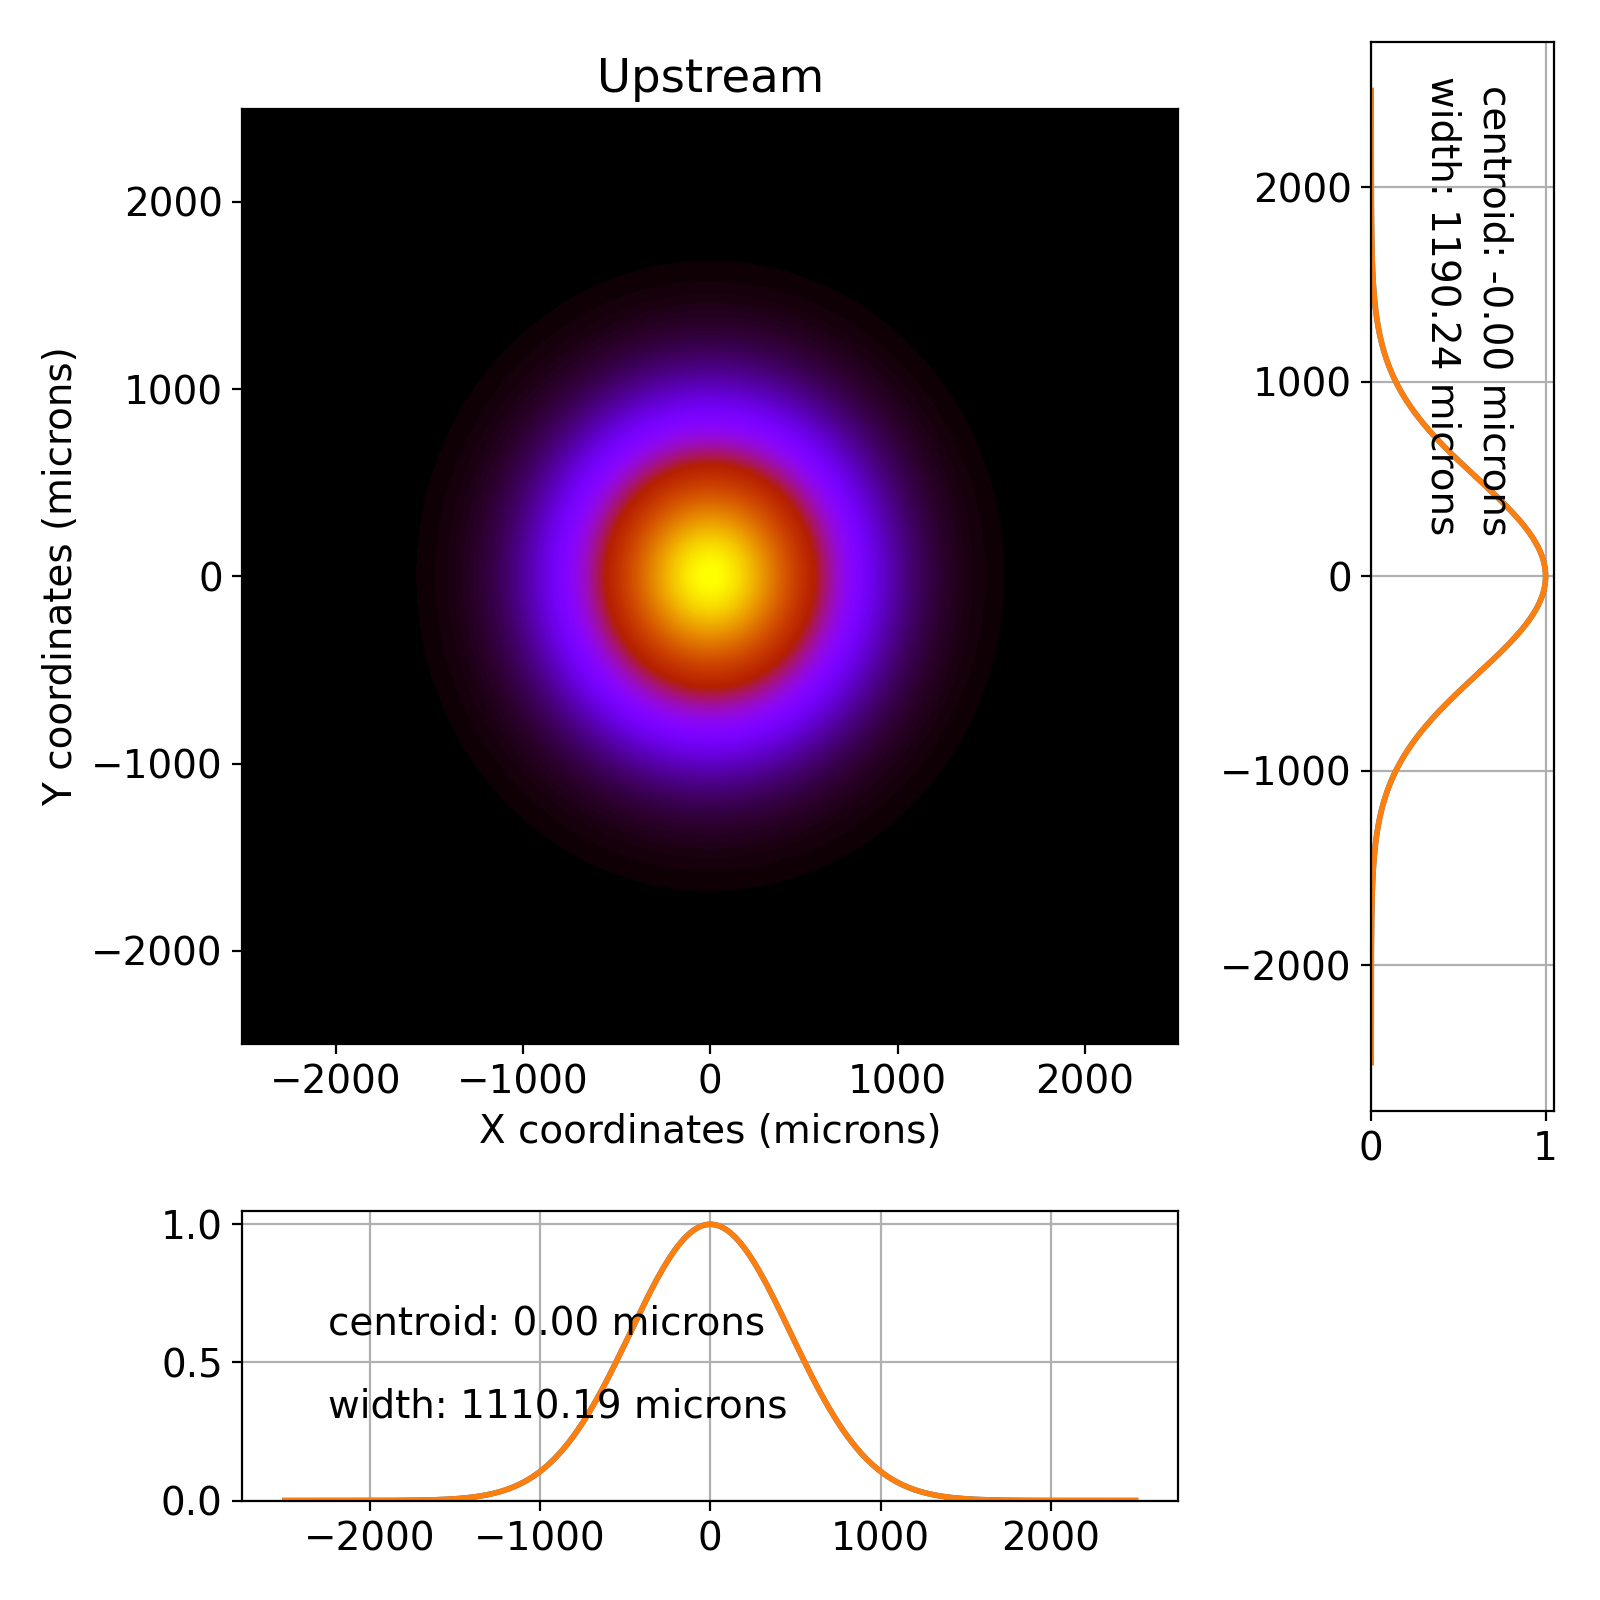

<IPython.core.display.Javascript object>


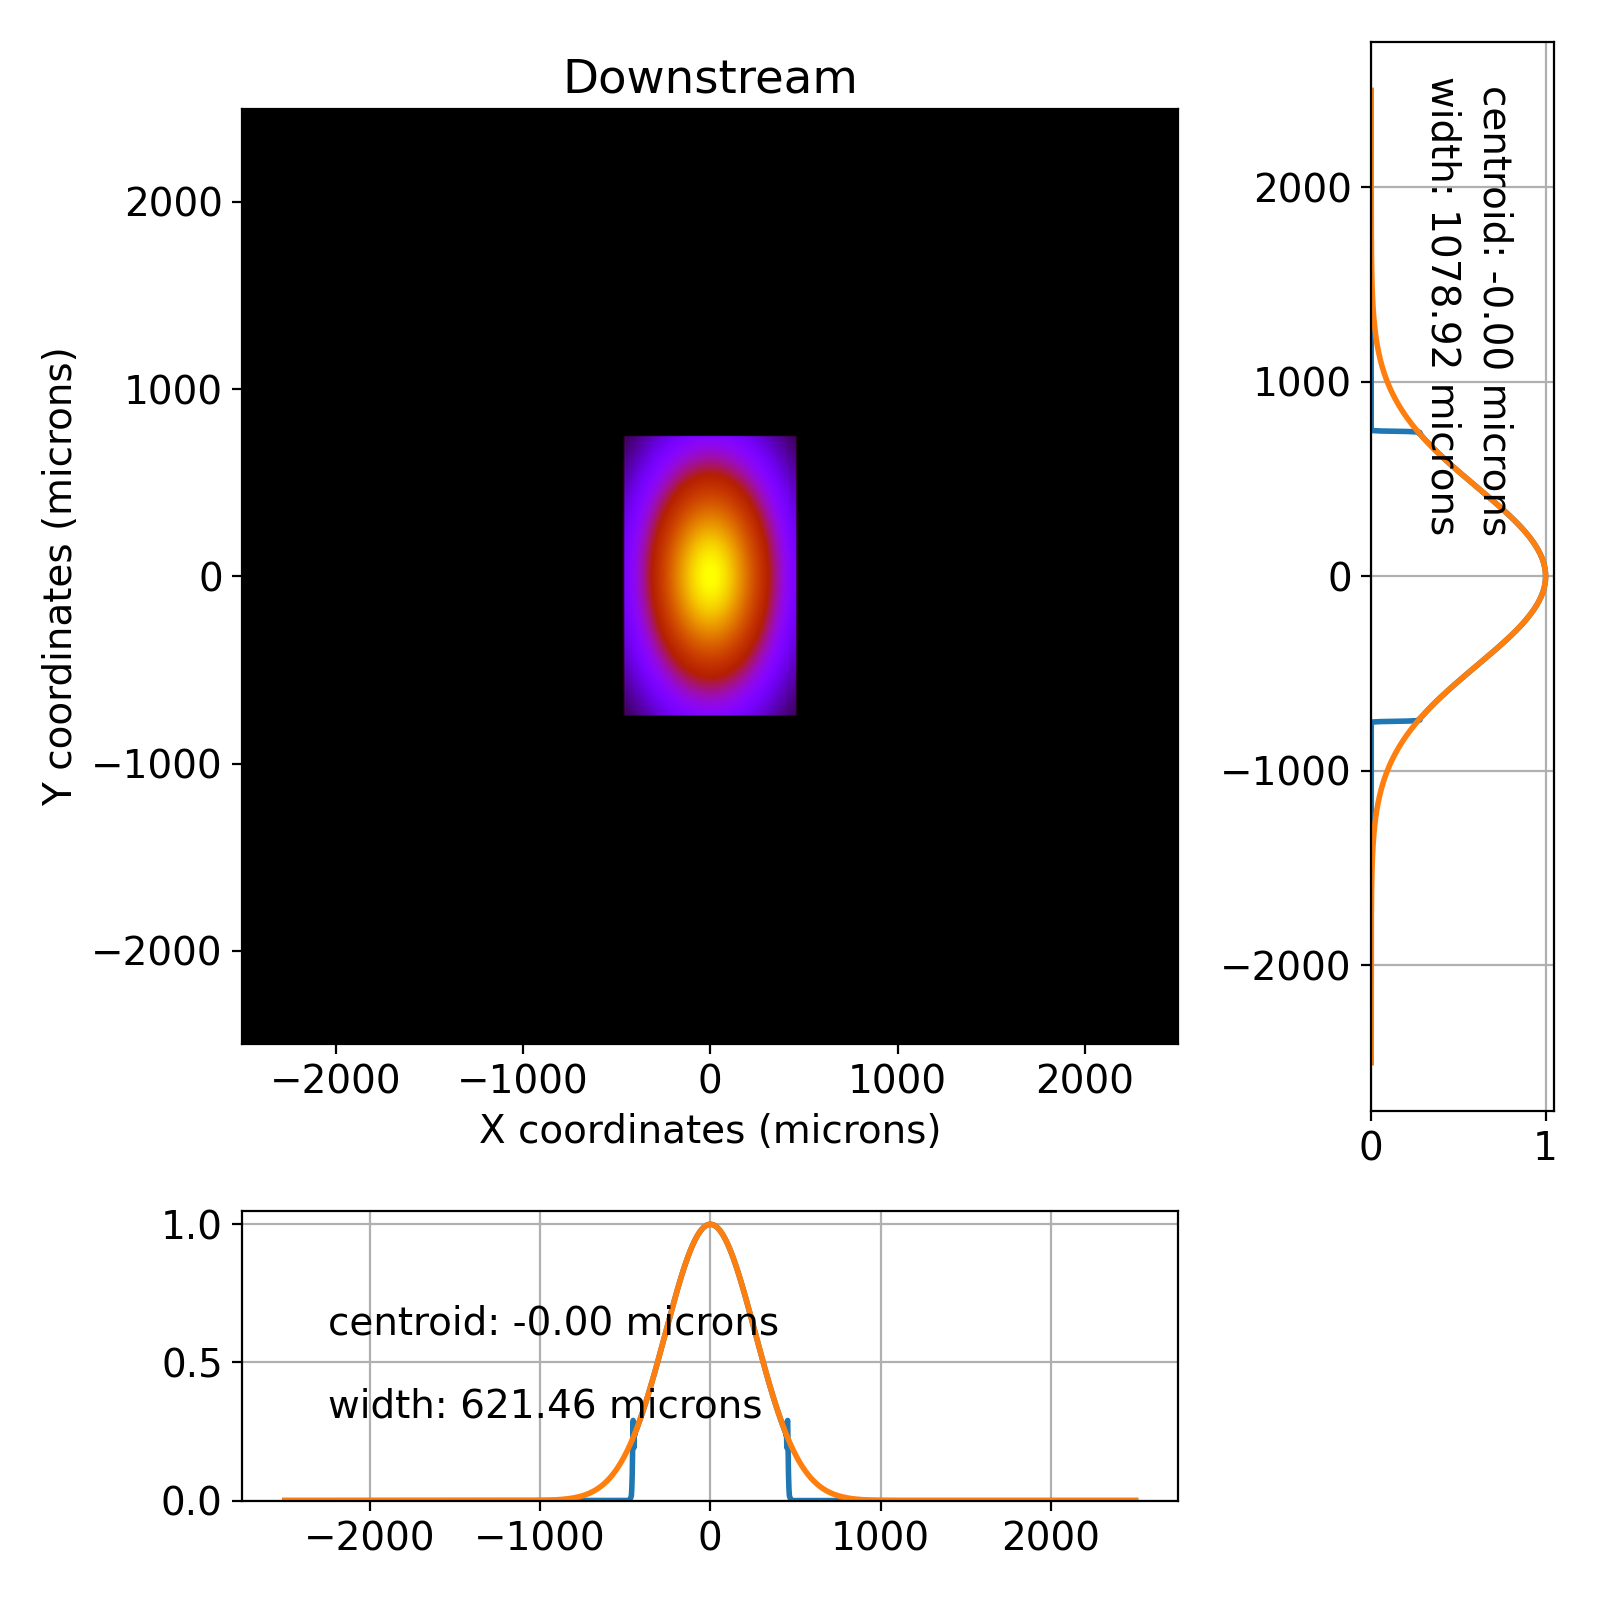

<IPython.core.display.Javascript object>


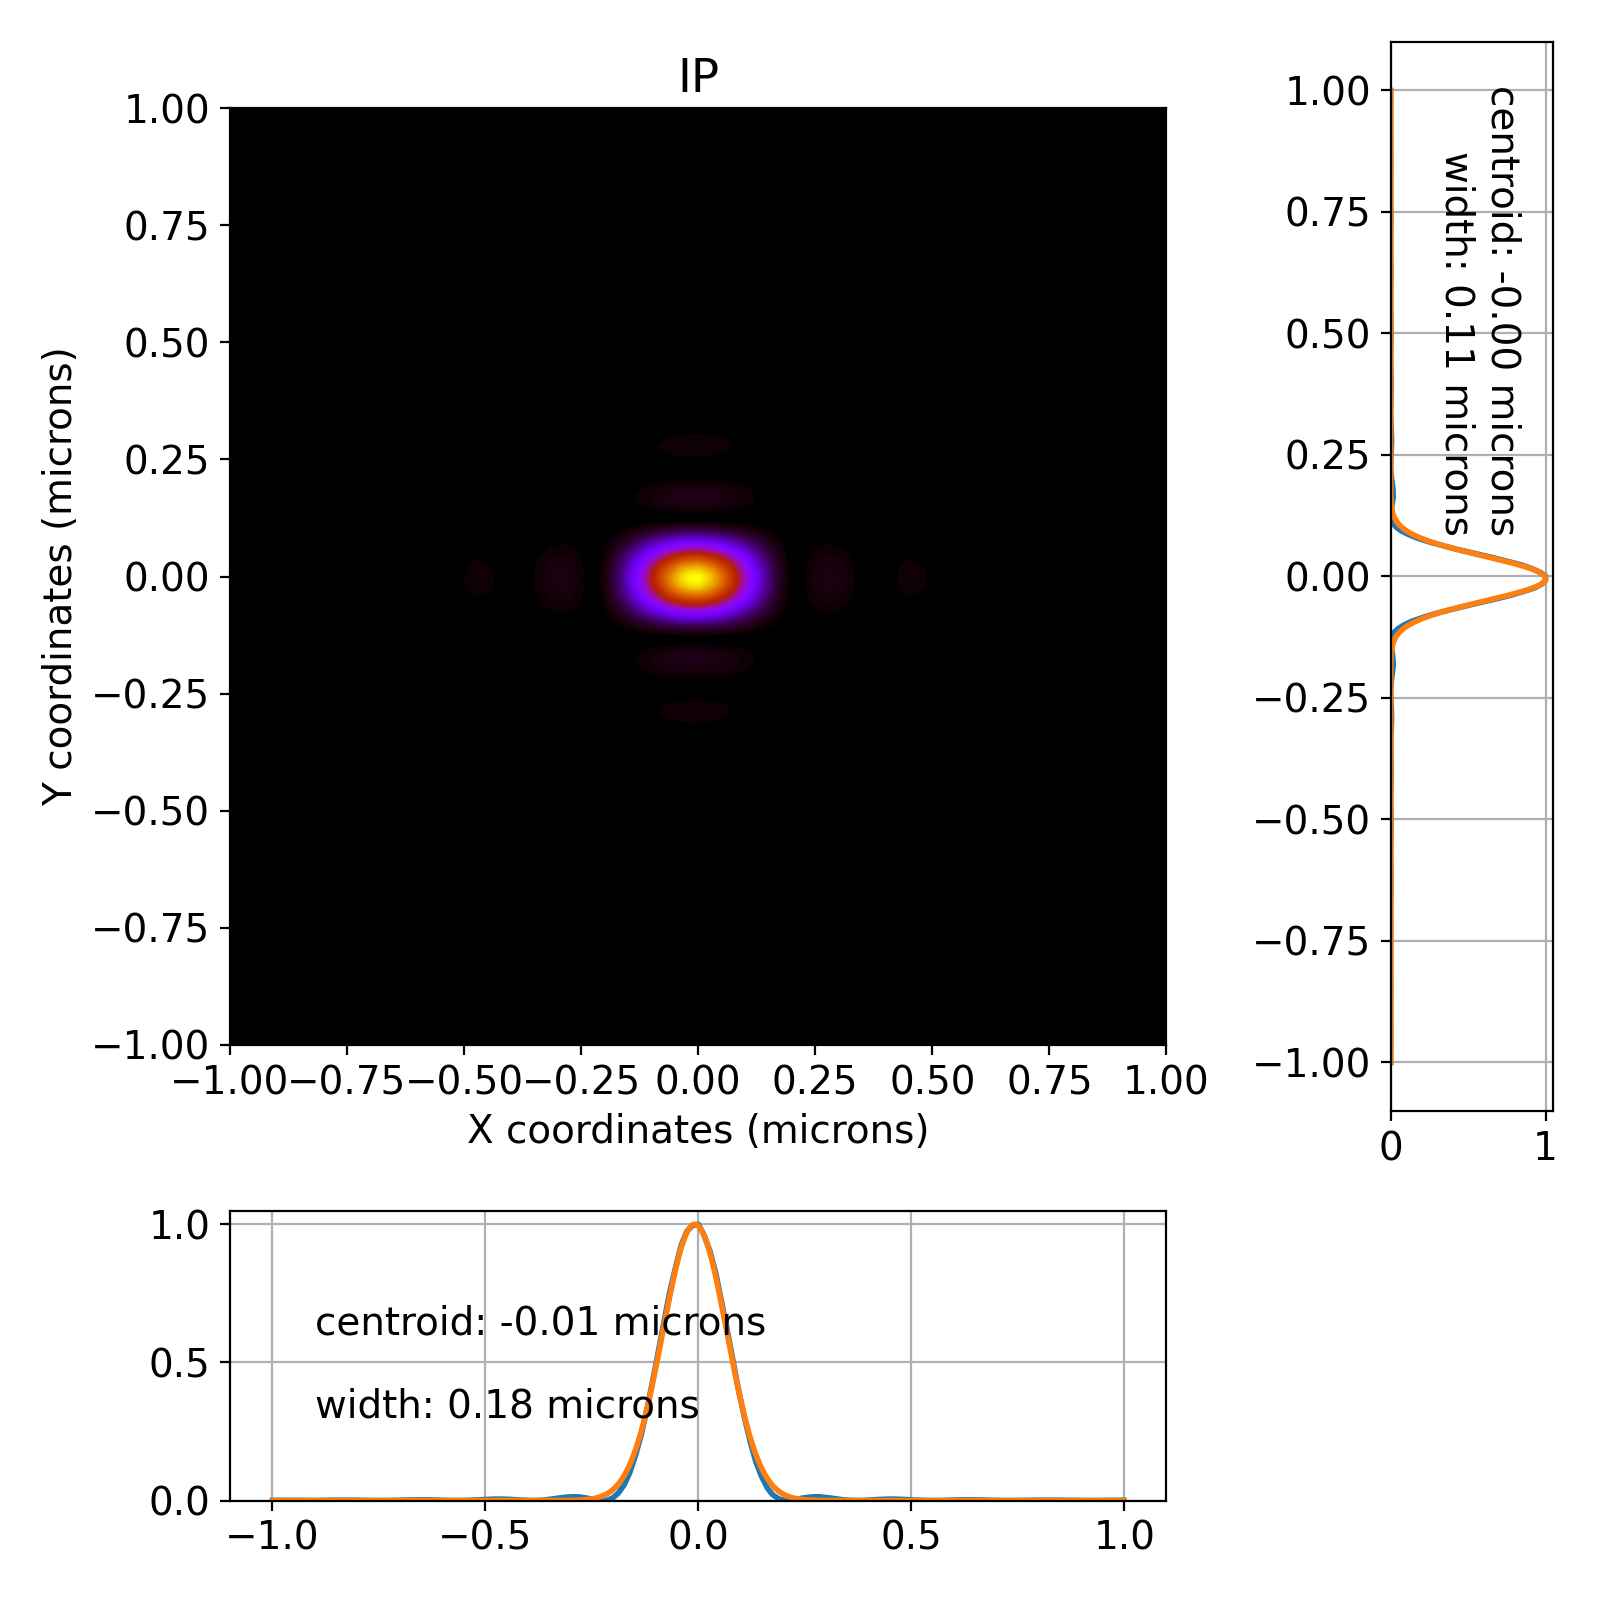

In [25]:
# propagate
b2 = L_beamline.propagate_beamline(b1)

fig_path = '/Users/seaberg/OneDrive - SLAC National Accelerator Laboratory/Beam Delivery/CXI HE upgrade/'

L_beamline.Upstream.view_beam()
plt.savefig(fig_path+'upstream_100nm.png')
L_beamline.Downstream.view_beam()
plt.savefig(fig_path+'downstream_100nm.png')
L_beamline.IP.view_beam()
plt.savefig(fig_path+'IP_100nm.png')

In [33]:
L_beamline.IP.view_horizontal(ax=ax,show_fit=False,label='perfect',legend=True)

<IPython.core.display.Javascript object>


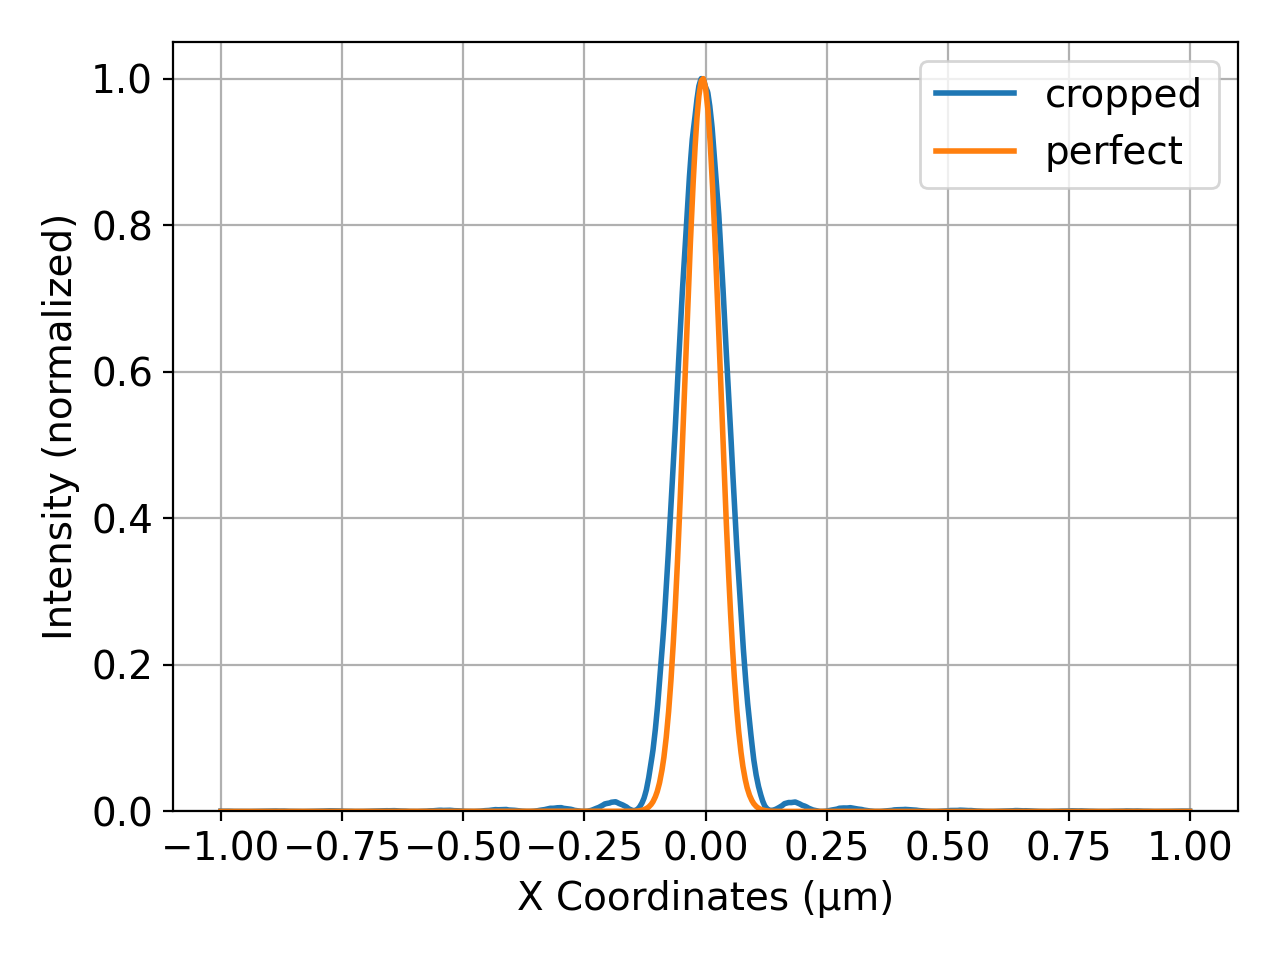

In [30]:
ax = L_beamline.IP.view_horizontal(show_fit=False,label='cropped')

In [26]:
ax.set_ylim(1e-8,1.1)

(1e-08, 1.1)

In [34]:
fig_path = '/Users/seaberg/OneDrive - SLAC National Accelerator Laboratory/Beam Delivery/CXI HE upgrade/'
plt.savefig(fig_path+'linear_comparison_100nm.png')

<IPython.core.display.Javascript object>


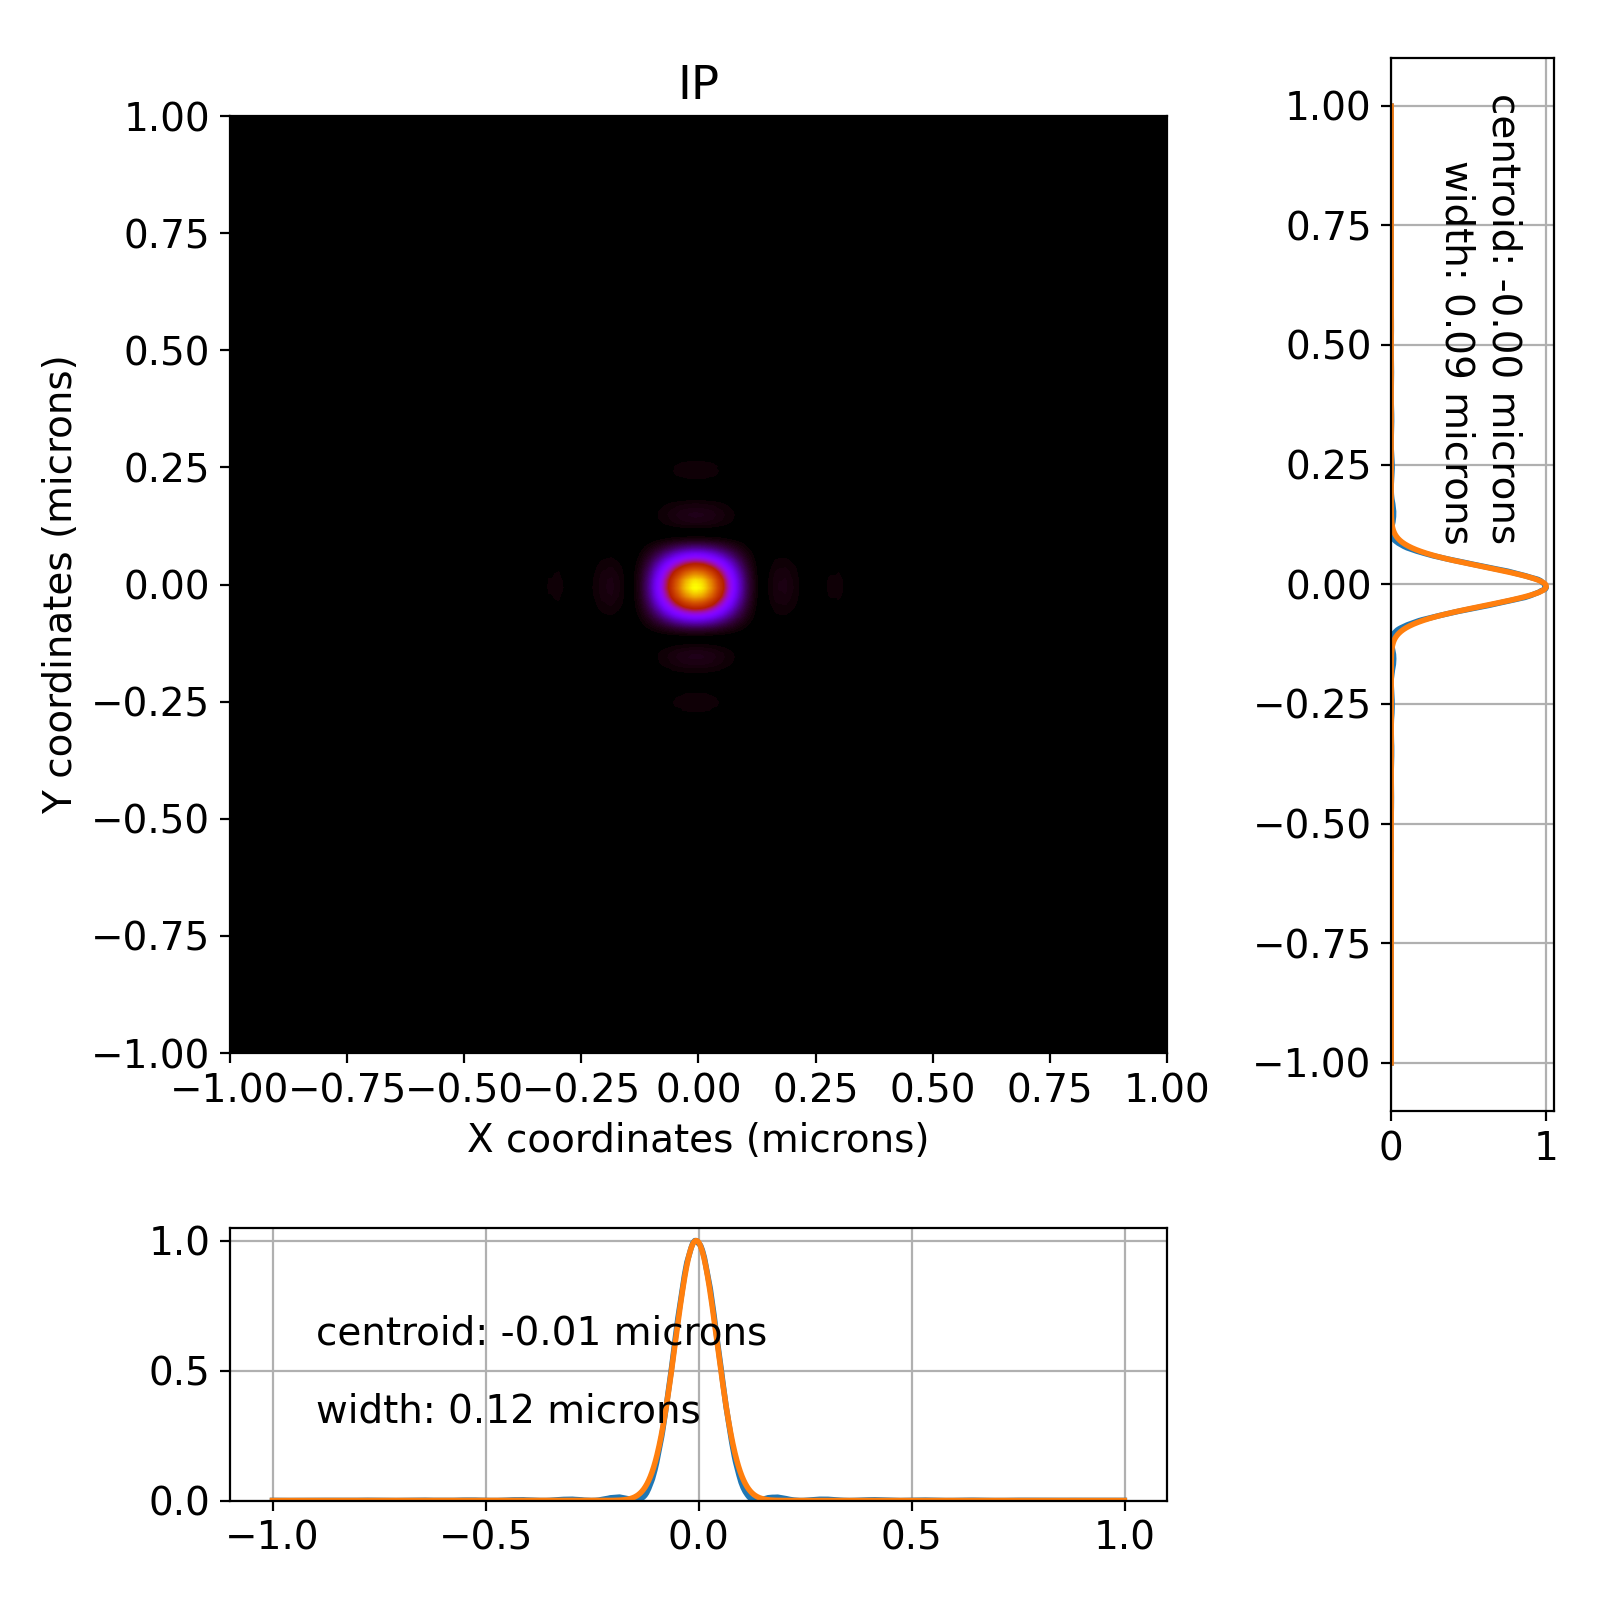

In [20]:
L_beamline.IP.view_beam()